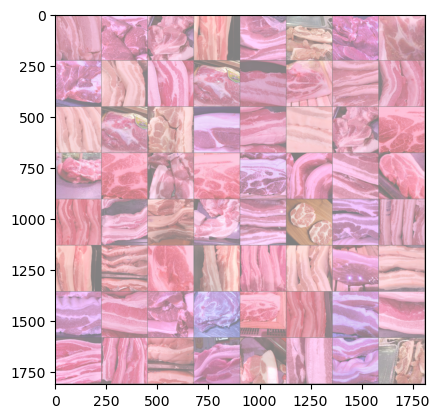

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms, datasets#
from torch.utils.data import DataLoader#
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from torch.utils import data
from PIL import Image

transforms = transforms.Compose([
    transforms.Resize(256),    # 将图片短边缩放至256，长宽比保持不变：
    transforms.CenterCrop(224),   #将图片从中心切剪成3*224*224大小的图片
    transforms.ToTensor()          #把图片进行归一化，并把数据转换成Tensor类型
]) 

path = r'C:/Users/beichen/dataset/pork'
 
data_train = datasets.ImageFolder(path, transform=transforms)
 
data_loader = DataLoader(data_train, batch_size=64, shuffle=True)
 

import matplotlib.pyplot as plt

#构建展示图片的函数
def imshow(img):
    img=img/2+0.5
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

#从数据迭代器中读取一张图片
dataiter=iter(data_loader)
images,labels=dataiter.next()

#展示图片
imshow(torchvision.utils.make_grid(images))
#打印标签
#print(''.join('%5s'% classes[labels[j]] for j in range(4)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #定义两个卷积层
        self.conv1=nn.Conv2d(3,6,5)#有RGB的图片第一个参数channel应该为3,这里为了看size的变化才写1的
        self.conv2=nn.Conv2d(6,16,5)
        #定义池化层
        self.pool=nn.MaxPool2d(2,2)
        #定义三个全连接层
        self.fc1=nn.Linear(16*53*53,120)#16*5*5
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)

    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        #变换x的形状以适配全连接层的输入
        #print(x.shape)
        x=x.view(-1,16*53*53)#5 5
        #print(x.shape)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)

        return x
#input[1, 1, 32, 32]->conv1poll[1, 6, 14, 14]->conv2pool[1, 16, 5, 5]->view[1, 400]->linear1relu[1, 120]->linear2relu[1,84]->linear3relu[10]
net=Net()
print(net)
import torch.optim as optim

#定义损失函数，选用交叉熵损失函数
criterion=nn.CrossEntropyLoss()
#定义优化器，选用随机梯度下降的优化器
#optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)


#改为选用adam优化算法
# define the Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [8]:
#编写训练集代码
for epoch in range(10):
    running_loss=0.0
    #按批次迭代训练模型
    for i,data in enumerate(data_loader,0):#ps修改括号内
        #从data中去除含有输入图像的张量inputs，标签张量labels
        inputs,labels=data
        #第一步梯度清零
        optimizer.zero_grad()
        #第二步将输入图像进入网络中，得到输出张量
        outputs=net(inputs)
        #计算损失值
        loss=criterion(outputs,labels)
        #进行反向传播和梯度更新
        loss.backward()
        optimizer.step()

        #打印训练的信息
        running_loss+=loss.item()
        if (i+1)%200==0:
            print('[%d,%5d] loss:%.3f'%(epoch+1,i+1,running_loss/200))
            running_loss=0.0

print('Finished training')


KeyboardInterrupt: 

In [43]:
#设定模型的保存位置
PATH='./ceshi.pth'
#保存模型的状态字典
torch.save(net.state_dict(),PATH)#***********************************************

#在GPU上训练模型
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#将模型转移到GPU上
net.to(device)

#将输入的图片张量和标签张量转移到GPU上
inputs,labels=data[0].to(device),data[1].to(device)

cuda:0


In [9]:
from PIL import Image,ImageFont,ImageDraw
import torch
#from MyModel import mymodel
import PIL
import cv2
from torchvision import transforms
import numpy as np

#image = Image.open(r"C:/Users/beichen/dataset/pork/class2/IMG_2472.jpg")
#image.show()

class_names = ['0','1']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net()#mymodel([3,32,32])
model.load_state_dict(torch.load("ceshi.pth"))
model.to(device)
model.eval()
print(model)
img_path = "C:/Users/beichen/dataset/pork/class2/IMG_20230329_185947.jpg"

transform_valid = transforms.Compose([
    transforms.Resize((227, 227)),    #?????????
    transforms.ToTensor()
  ]
)
img = Image.open(img_path)
img_ = transform_valid(img).unsqueeze(0) #拓展维度

img_ = img_.to(device)
outputs = model(img_)

_, indices = torch.max(outputs,1)
percentage = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
perc = percentage[int(indices)].item()
result = class_names[indices]
print('预测类别为:', result,'(0代表五花肉，1代表梅花肉)')

#得到预测结果，并且从大到小排序
_, indices = torch.sort(outputs, descending=True)
#打印每个预测值的百分数
percentage = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
print([(class_names[idx], percentage[idx].item()) for idx in indices[0][:2]])

# bk_img = cv2.imread("C:/Users/.../file.jpg")
# #设置需要显示的字体
# fontpath = "font/simsun.ttc"
# font = ImageFont.truetype(fontpath, 32)
# img_pil = Image.fromarray(bk_img)
# draw = ImageDraw.Draw(img_pil)
# draw.text((20, 30),  "这张图片的类别可能是："+str(result), font = font, fill = (25, 25, 25))
# bk_img = np.array(img_pil)
# cv2.imshow("add_text",bk_img)
# cv2.waitKey()
# cv2.imwrite("add_text.jpg",bk_img)


# 创建一个照片文件
image = Image.open(img_path)
fontpath = "font/simsun.ttc"
font = ImageFont.truetype(fontpath, 50)
draw = ImageDraw.Draw(image)



text = "这张图片中肉的类别可能是："+str(result)+"\n<0代表五花肉\n1代表梅花肉>\n"

# drawing text size
draw.text((50, 50), text, font=font,fill='yellow', align="left")

image.show()


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
预测类别为: 0 (0代表五花肉，1代表梅花肉)
[('0', 62.621307373046875), ('1', 37.37832260131836)]
